In [66]:
import math
import torch
import numpy as np
from torch import nn
from torch.nn import init
from torch.nn.modules import loss

In [67]:
import matplotlib
import matplotlib.pyplot as plt
from IPython.display import clear_output
%matplotlib inline

## Восставновление матрицы малого ранга (2 балла)

Есть неизвестная матрица X_taget. (В тетрадке она хранятся явно, для самопроверки)
X_noised - зашумленная матрица, по которой нужно восстановить X_taget.

Для решения задачи. Нужно задать две матрицы $H$, $W$ и найти минимум $|| W * H = X_{noisy} ||$ методом градиентного спуска.

Напишите градиетный спуск и подберите learning rate и количетсво итераций. 

In [68]:
def get_X():
    np.random.seed(12345)
    W_ = np.random.randn(73, 6)
    H_ = np.random.randn(6, 46)
    X_taget = W_.dot(H_)
    return torch.tensor(X_taget), torch.tensor(X_taget + np.random.randn(73, 46) * 0.1)

In [69]:
X_taget, X_noisy = get_X()
print(X_noisy.shape, np.linalg.matrix_rank(X_noisy))

torch.Size([73, 46]) 46


In [70]:
def dist(X1, X2):
    d = (X1 - X2) ** 2
    return d.mean()

In [71]:
W = torch.tensor(np.random.randn(73, 6), requires_grad=True)
H = torch.tensor(np.random.randn(6, 46), requires_grad=True)

In [72]:
# Минимизируейте dist(X_taget, W.matmul(H))


val = dist(X_noisy, W.matmul(H))
error = 0.008
while val > error:
    val.backward()
    with torch.no_grad():
        W -= W.grad
        H -= H.grad
    W.grad = None
    H.grad = None
    val = dist(X_noisy, W.matmul(H))


In [73]:
X_taget, W.matmul(H), dist(X_taget, W.matmul(H))

(tensor([[-0.8714, -1.0437,  2.6547,  ..., -0.9536,  0.1898,  0.5202],
         [-2.8459,  1.5371, -3.1096,  ...,  0.1686,  1.4262,  0.0879],
         [ 1.7662, -2.0571, -1.7443,  ...,  1.3217, -0.2828, -0.0890],
         ...,
         [-0.9121, -1.2727,  3.2953,  ..., -2.8577,  0.1717,  0.8798],
         [ 3.6893,  2.0530,  0.1916,  ...,  3.2116, -1.5225, -0.4281],
         [ 2.6561, -1.7660,  0.3288,  ...,  1.8210, -0.9676, -0.7939]],
        dtype=torch.float64),
 tensor([[-0.9010, -1.0849,  2.7149,  ..., -0.9301,  0.1952,  0.5061],
         [-2.8849,  1.4266, -3.0875,  ...,  0.2205,  1.4400,  0.0317],
         [ 1.8048, -2.0711, -1.6970,  ...,  1.2833, -0.2863, -0.0463],
         ...,
         [-0.8547, -1.2350,  3.3116,  ..., -2.8089,  0.1445,  0.8877],
         [ 3.7858,  2.0639,  0.1514,  ...,  3.1917, -1.4821, -0.3601],
         [ 2.5642, -1.7813,  0.3217,  ...,  1.7662, -0.9657, -0.7818]],
        dtype=torch.float64, grad_fn=<MmBackward0>),
 tensor(0.0024, dtype=torch.float64

In [74]:
dist(X_noisy, W.matmul(H))

tensor(0.0080, dtype=torch.float64, grad_fn=<MeanBackward0>)

In [75]:
W = W
H = H

In [76]:
...

Ellipsis

In [77]:
base_dist = dist(X_noisy, X_taget).item()
recoverd_dist = dist(W.matmul(H), X_taget).item()

In [78]:
# Восстановленая матрица должна быть ближе к исходной чем шумная
print(f"Distance to noisy matrix:     {base_dist}")
print(f"Distance to recovered matrix: {recoverd_dist}")

Distance to noisy matrix:     0.010014712528201112
Distance to recovered matrix: 0.0023731683813962043


In [79]:
assert recoverd_dist < base_dist

# Брахистохрона [4 балла]

Задача о нахождении кривой наискорейшего спуска, или *брахистохроны*, состоит в том, чтобы найти такую форму горки, чтобы время скатывания  по ней тела без трения было минимальным. 

<img src="https://upload.wikimedia.org/wikipedia/commons/6/63/Brachistochrone.gif" style="background:white" />

Известно, что решение этой задачи - трансцедентная кривая, называемая [циклоидой](https://ru.wikipedia.org/wiki/%D0%A6%D0%B8%D0%BA%D0%BB%D0%BE%D0%B8%D0%B4%D0%B0). Кроме того, что это кривая минимизирует время спуска, она является траекторией точки на границе катящейся окружности, время спуска по этой кривой не зависит от начального положения, а еще маятник в часах имеет циклоидальный ограничитель, благодаря чему частота его колебаний не зависит от амплитуды.

<img src="https://upload.wikimedia.org/wikipedia/commons/b/bd/Tautochrone_curve.gif" style="background:white" />
<img src="https://upload.wikimedia.org/wikipedia/commons/c/cd/Isochronous_cycloidal_pendula.gif" style="background:white" />
<img src="https://upload.wikimedia.org/wikipedia/commons/6/69/Cycloid_f.gif" style="background:white" /> 

Эта залача была поставлена Иоганном Бернулли в 1696 году. Разные решения предлагали Исаак Ньютон, Якоб Бернулли, Г. В. Лейбниц, Г. Ф. Лопиталь, Э. В. Чирнхаус. Скорее всего, вы уже находили ее на курсе по вариационному исчислению, минимизируя значение какого-то там интеграла. Здесь же предлагается приблизить брахстохрону при помощи функционала pytorch.

In [80]:
# константы-параметры вашей горки. Для простоты будем считать, что верхняя точка
# имеет координаты (0, HEIGHT), нижняя -- (WIDTH, 0). Обязательно возьмите другие числа!
HEIGHT = 40
WIDTH = 50
g = 9.8
# Будем апроксимировать бразистохрону  кусочно-линейной функцией, тут число отрезков
NUM_POINTS = 20

Начнем с того, что отрисуем сразу правильный ответ, чтобы сравнивать с ним то, что получается у нас. Для этого я воспользуюсь оригинальным [cпособом](https://en.wikipedia.org/wiki/Brachistochrone_curve#Indirect_method) Бернулли-младшего:

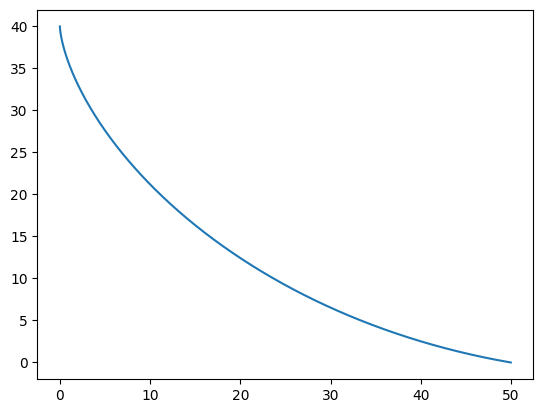

In [81]:
from scipy import optimize

# отрисуем правильный ответ:
fig = plt.figure()
ax = fig.add_subplot(111)

# Находим такую циклоиду, у которой точка невозврата находится на вершине нашей горки
def func(theta):
    return (1 - np.cos(theta)) / (theta - np.sin(theta)) - HEIGHT / WIDTH

# By the way, вот это считается самым эффективным поиском нулей функции на отрезке. 
# Должно работать сильно лучше, чем бинпоиск или метод Ньютона.
# Упражнение: вернитесь в первую практику и сравните время работы с бинпоиском
theta = optimize.brentq(func, 0.01, 2*np.pi)

# Считаем всю циклоиду на (0, 2pi)
r = WIDTH / (theta - np.sin(theta))
ts = np.linspace(0, 2 * np.pi, 10000)
sol_xs = r * (ts - np.sin(ts))
sol_ys = HEIGHT - r * (1 - np.cos(ts))

# убираем лишнее
rng = sol_xs < WIDTH + 1e-8
sol_xs = sol_xs[rng]
sol_ys = sol_ys[rng]

ax.plot(sol_xs, sol_ys)
fig.canvas.draw()
plt.show(block=False)

# P.S. Если вас пугают эти явные формулы, можно узнать откуда они по ссылке выше.

Теперь к нашему приближению. Как уже упоминалось, оно будет кусочно-линейным: мы зафиксируем `NUM_POINTS` точек на горизонтальной оси, расположенных через одинаковые промежутки от `0` до `WIDTH`. В этих точках будут изломы нашей кусочно-линейной аппроксимации, а высоты мы будем менять в процессе "обучения".

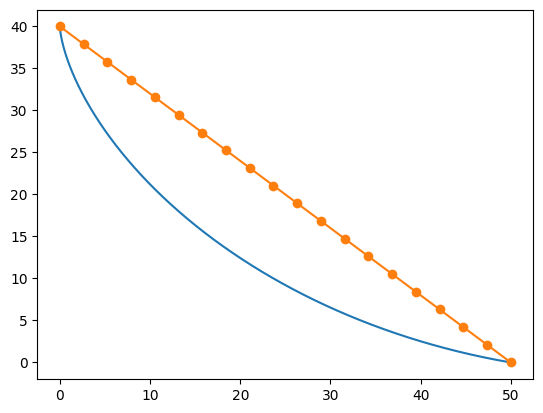

In [82]:
xs = torch.linspace(0, WIDTH, NUM_POINTS)
# инициализируем горку прямой
ys = torch.linspace(HEIGHT, 0, NUM_POINTS, requires_grad=True)
dxs = torch.tensor([xs[i] - xs[i-1] for i in range(1, NUM_POINTS)]) 
fig = plt.figure()
ax = fig.add_subplot(111)
ax.plot(sol_xs, sol_ys)
li, = ax.plot(xs.numpy(), ys.detach().numpy(), marker='o')


In [83]:
# Эта функция должна для каждой точки из xs вычислить время, спустя которе 
# скользящее тело окажется в той или иной точке. 

# Подсказка: вспомните закон сохранения механической энергии из школьного курса физики!

def get_time(ys): 
    """
    :param ys: высоты наших точек
    :return: время, через которое каждая из точек будет достигнута
    """
    vs = (2 * g * (HEIGHT - ys))**(1/2)  # скорость в каждой точке
    dys = torch.diff(ys) # изменение высоты
    lengths = (dys**2 + dxs**2)**(1/2) # длина сегмента
    sum = vs[0:NUM_POINTS - 1] + vs[1:NUM_POINTS]
    times = 2 * lengths / sum  # Время достижения каждой точки
    return times

Epoch: 18000 time: [1.4167689  0.33752054 0.25131738 0.2078799  0.18104598 0.1626224
 0.14911345 0.13876137 0.1305711  0.12393715 0.11846667 0.11389475
 0.1100359  0.10675643 0.10395756 0.10156562 0.09952512 0.09779273
 0.09633626]


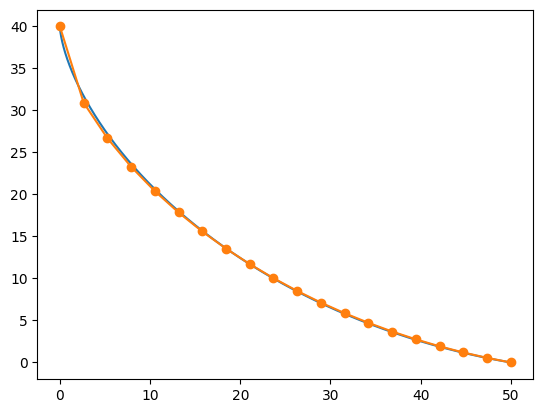

In [84]:
lr = 0.7
for epoch in range(20000):
    
    ts = get_time(ys)
    loss = ts.sum()
    loss.backward()
    with torch.no_grad():
        # обновим наши точки
        ys[1:-1] -= lr * ys.grad[1:-1]
        # Что-то еще?
    ys.grad = None
    
    if epoch % 2000 == 0:
        # интерактивная визуализация! обновляем график каждые 2000 эпох
        
        # осторожно: слишком частые clear_output могут привести к
        # неадекватному поведению matplotlib до следующей перезагрузки кернела
        clear_output(wait=True)
        print(f"Epoch: {epoch} time: {ts.detach().numpy()}")
        fig = plt.figure()
        ax = fig.add_subplot(111)
        ax.plot(sol_xs, sol_ys)
        li, = ax.plot(xs, ys.detach(), marker='o')
        fig.canvas.draw()
        plt.show()